In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preprocessing

## Dataset creation

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

# Test

In [46]:
fluorescence_df = fp_df.copy()

# Sort the dataframe by depth_continuous column
fluorescence_df = fluorescence_df.sort_values(by=['week', 'year', 'month', 'depth']).drop_duplicates(['week', 'year', 'month', 'depth'])

# Calculate the differences between consecutive values
fluorescence_df['depth_diff'] = fluorescence_df['depth'].diff().abs()

# Find the smallest change
smallest_change = fluorescence_df['depth_diff'].min()

smallest_change

0.00999999999999801

## Fluorprobe outliers exploration

In [5]:
fp_df['depth_discrete'] = fp_df['depth'].apply(lambda x: min(biomass_by_week_year_group['Depth'], key=lambda y: abs(y - x)))

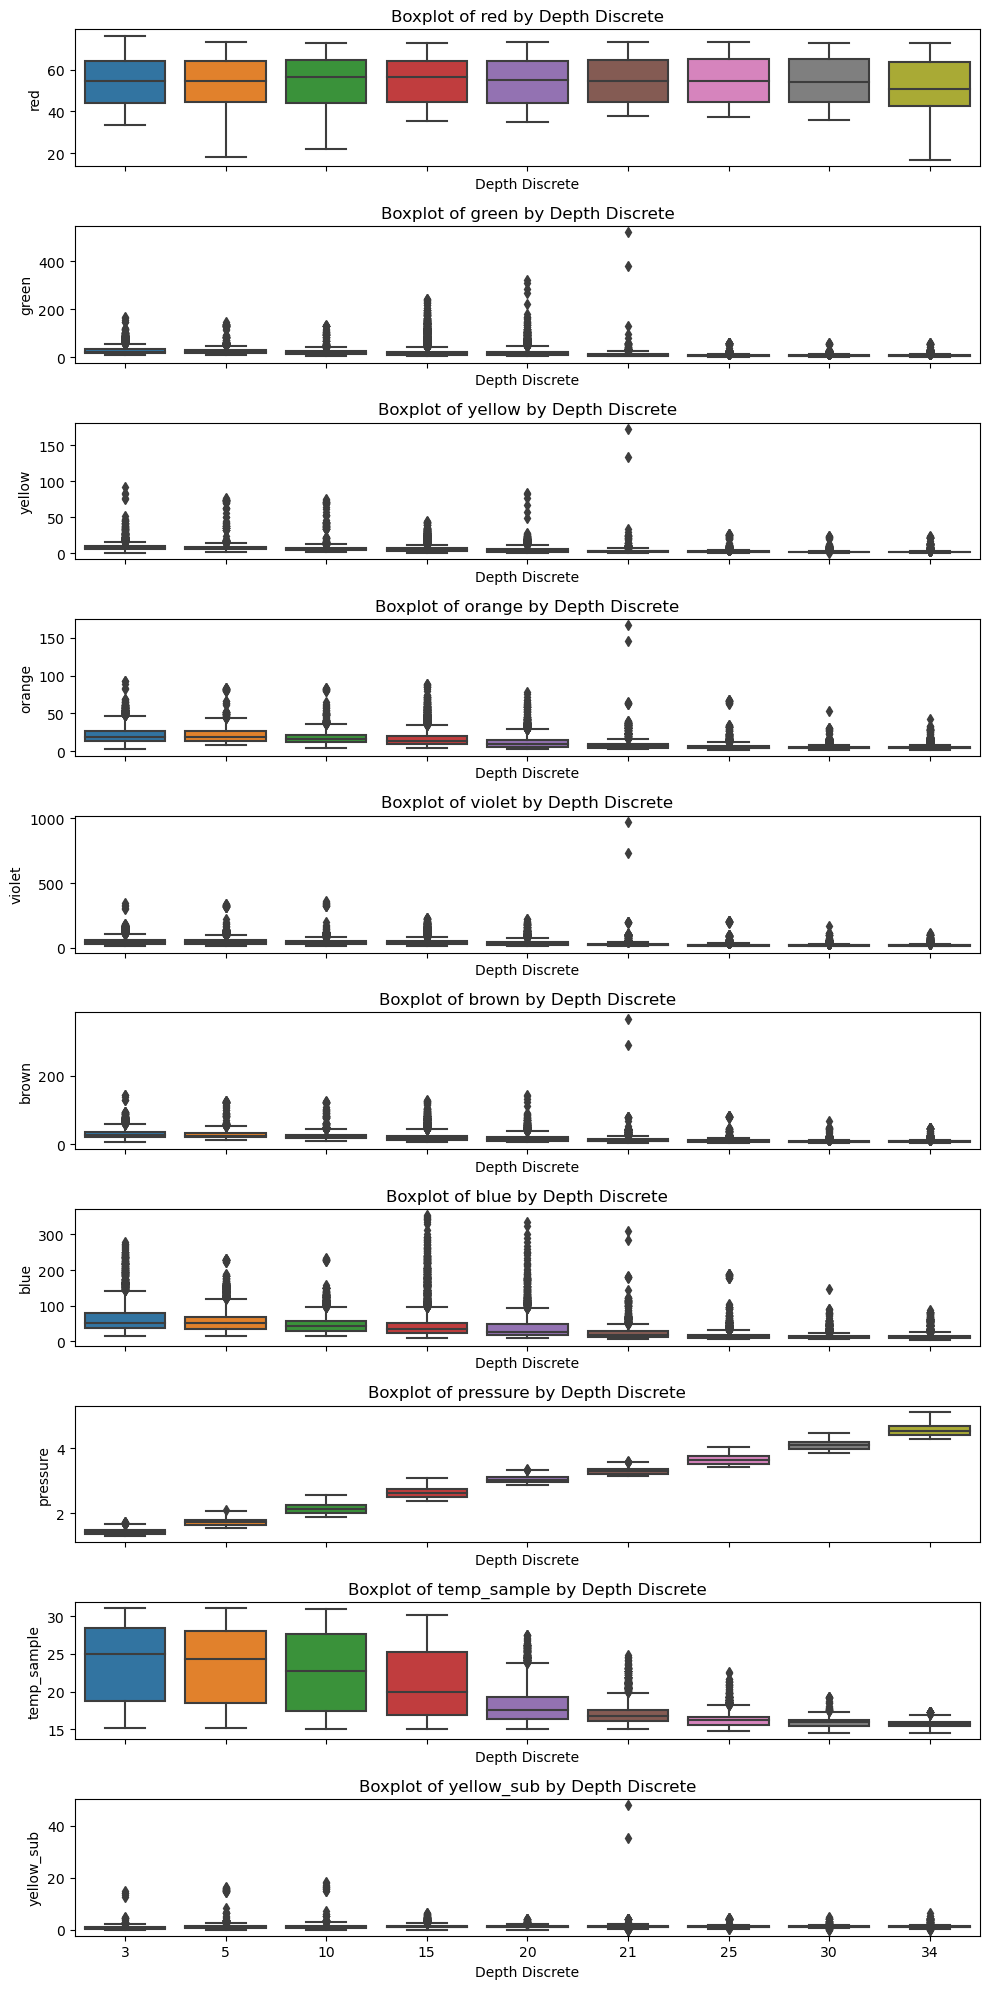

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded and prepared your DataFrame 'fp_df'

# List of signals you want to plot
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub']

# Create subplots
fig, axes = plt.subplots(nrows=len(signals), ncols=1, figsize=(10, 20), sharex=True)

# Loop through each signal and create a boxplot
for idx, signal in enumerate(signals):
    ax = axes[idx]
    sns.boxplot(x='depth_discrete', y=signal, data=fp_df, ax=ax)
    ax.set_ylabel(signal)
    ax.set_xlabel('Depth Discrete')
    ax.set_title(f'Boxplot of {signal} by Depth Discrete')

plt.tight_layout()
plt.show()

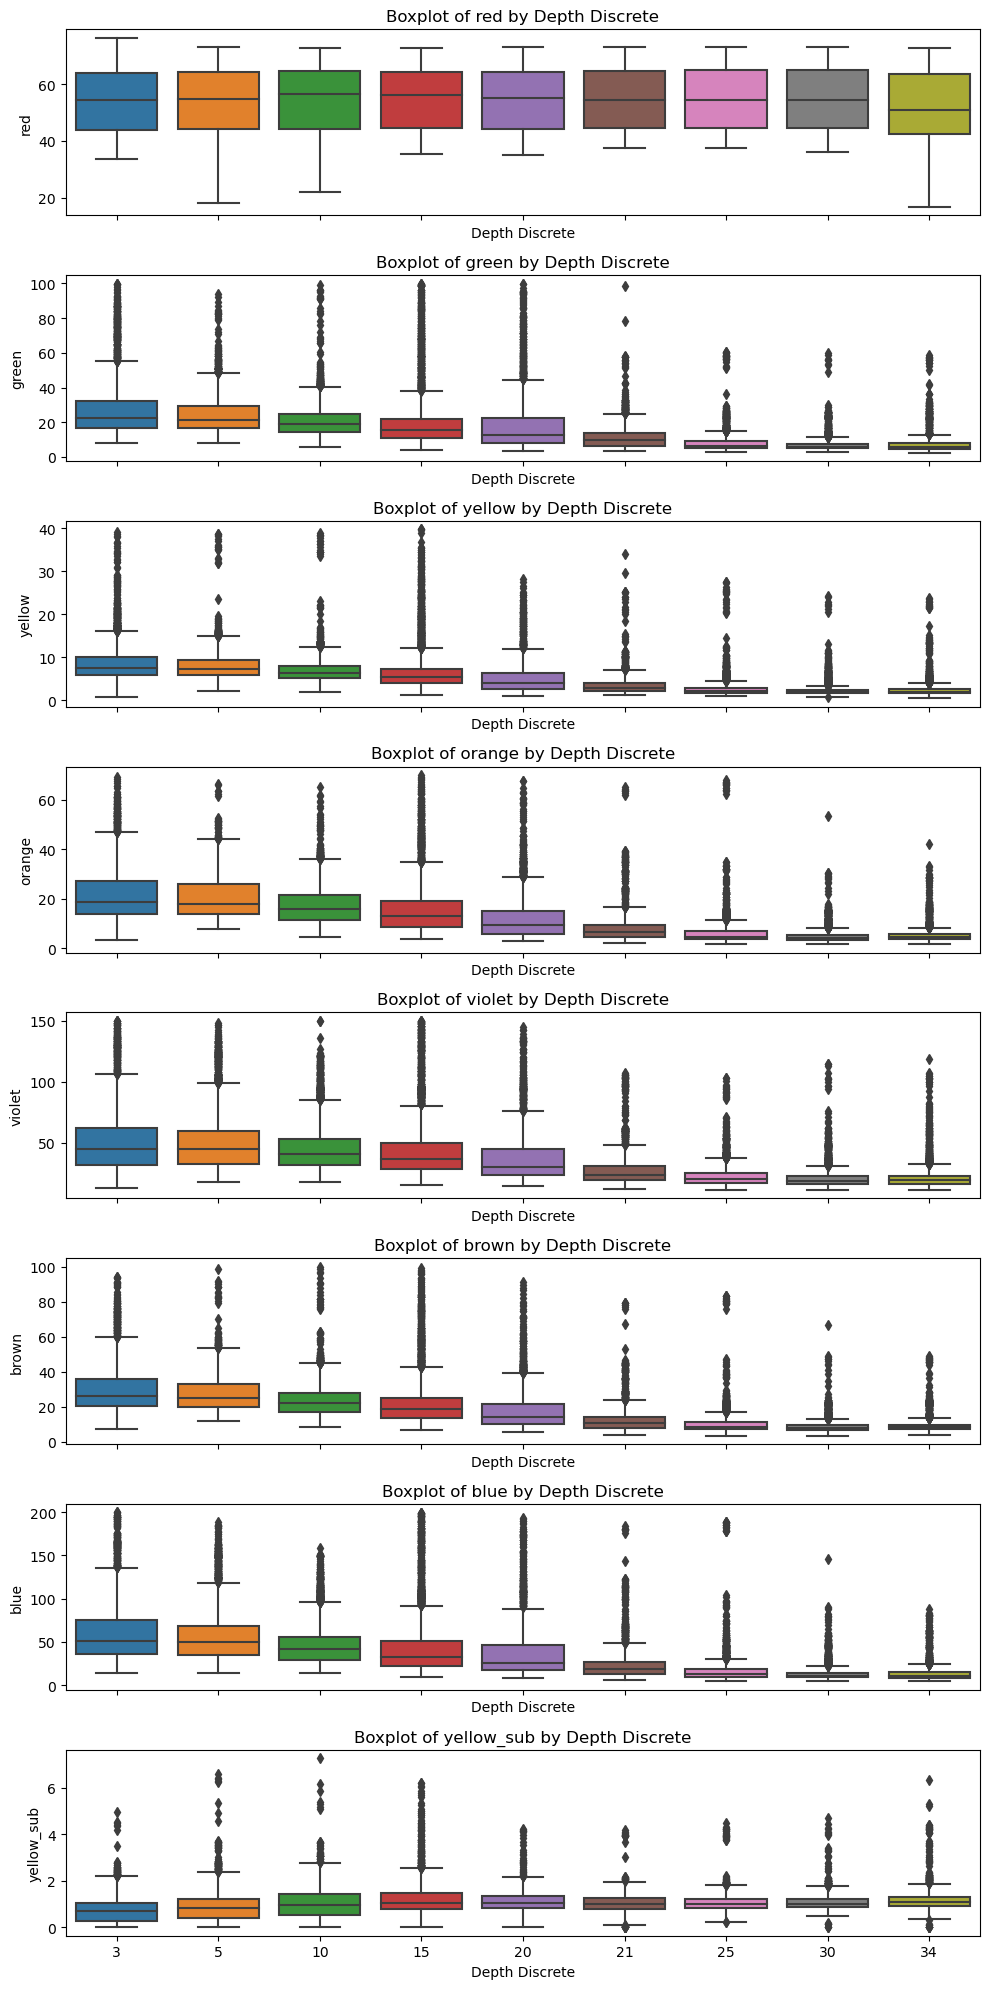

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded and prepared your DataFrame 'fp_df'

# List of signals you want to plot
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'yellow_sub']
# Dictionary to store records to be removed for each signal
records_to_remove = {signal: [] for signal in signals}

# Create subplots
fig, axes = plt.subplots(nrows=len(signals), ncols=1, figsize=(10, 20), sharex=True)

boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 100},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 70},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 100},
    'blue': {'lower_bound': 0, 'upper_bound': 200},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 8}

}
# Loop through each signal and create a boxplot
for idx, signal in enumerate(signals):
    ax = axes[idx]
    
    # Calculate IQR
#     q1 = fp_df[signal].quantile(0.25)
#     q3 = fp_df[signal].quantile(0.75)
#     iqr = q3 - q1
    
    # Define upper and lower bounds to filter out outliers
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
    lower_bound = boundaries[signal]['lower_bound']
    upper_bound = boundaries[signal]['upper_bound']
    
    # Filter the DataFrame
    filtered_df = fp_df[(fp_df[signal] >= lower_bound) & (fp_df[signal] <= upper_bound)]
    
    # Identify records to be removed
    outliers = fp_df[(fp_df[signal] < lower_bound) | (fp_df[signal] > upper_bound)]
    
    # Accumulate records to be removed
    records_to_remove[signal].extend(outliers.index.tolist())
    
    # Create the boxplot with the filtered data
    sns.boxplot(x='depth_discrete', y=signal, data=filtered_df, ax=ax)
    ax.set_ylabel(signal)
    ax.set_xlabel('Depth Discrete')
    ax.set_title(f'Boxplot of {signal} by Depth Discrete')

plt.tight_layout()
plt.show()


In [10]:
# Flatten the list of indices to remove
indices_to_remove = set(idx for lst in records_to_remove.values() for idx in lst)

# Remove accumulated records from 'fp_df'
filtered_df = fp_df.drop(index=indices_to_remove)
filtered_df

depth    red  green  yellow  orange  violet  brown   blue  pressure  \
18      1.53  62.74  21.95    6.85   17.53   48.68  24.67  49.79      1.30   
19      1.60  62.66  21.76    7.25   17.09   47.80  24.32  49.24      1.31   
20      1.71  62.43  21.45    7.45   17.27   48.64  24.72  50.14      1.32   
21      1.81  62.61  21.89    7.23   17.14   48.78  24.13  50.87      1.33   
22      1.95  62.65  21.80    7.37   17.84   48.13  24.91  49.41      1.34   
...      ...    ...    ...     ...     ...     ...    ...    ...       ...   
45189  36.56  41.90   6.95    2.75    5.40   20.68   9.50  11.33      4.73   
45190  37.02  42.14   6.86    2.45    5.18   20.54   9.27  10.87      4.78   
45191  37.43  41.99   7.12    2.60    5.49   21.09   9.59  11.70      4.82   
45192  37.69  42.01   7.03    2.67    5.22   20.78   9.58  11.20      4.85   
45193  38.10  42.05   7.05    2.67    5.12   20.70   9.58  11.07      4.89   

       temp_sample  yellow_sub  Green Algae  Bluegreen  Diatoms  Cryptophyta  \
18           19.93        1.20         9.74       0.29     1.63         5.95   
19           19.93        1.16         9.80       0.02     1.16         6.36   
20           19.93        1.16        10.77       0.00     0.63         6.45   
21           19.93        1.13        10.46       0.00     1.53         6.00   
22           19.93        1.16         9.92       0.27     1.16         6.29   
...            ...         ...          ...        ...      ...          ...   
45189        15.64        1.14         0.00       0.40     0.63         0.52   
45190        15.62        1.14         0.00       0.39     0.55         0.49   
45191        15.59        1.15         0.00       0.43     0.78         0.43   
45192        15.59        1.15         0.00       0.35     0.47         0.65   
45193        15.59        1.14         0.00       0.32     0.38         0.73   

       Total conc  week  year  month  depth_discrete  
18          17.62    49  2019     12               3  
19          17.33    49  2019     12               3  
20          17.84    49  2019     12               3  
21          17.99    49  2019     12               3  
22          17.64    49  2019     12               3  
...           ...   ...   ...    ...             ...  
45189        1.55    27  2022      7              34  
45190        1.43    27  2022      7              34  
45191        1.64    27  2022      7              34  
45192        1.48    27  2022      7              34  
45193        1.43    27  2022      7              34  

[38831 rows x 20 columns]

In [11]:
filtered_df.drop('depth_discrete', axis=1, inplace=True)

## Splitting to test temporarily & Extracting probe's test data

In [12]:
merged_df = merge_fp_biomass_df(filtered_df, biomass_by_week_year_group)

In [13]:
merged_df_test = merged_df[(merged_df['year'] == 2022) & (merged_df['month'] >= 4)]
merged_df = merged_df[~merged_df.index.isin(merged_df_test.index)]

orig_merged_df = merged_df.copy()

merged_df = merged_df.drop(['week'], axis=1)
merged_df_test = merged_df_test.drop(['week'], axis=1)

In [16]:
merged_df = merged_df.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_test_df = merged_df_test[['group_num', 'month', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_df_test = merged_df_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

# Plot

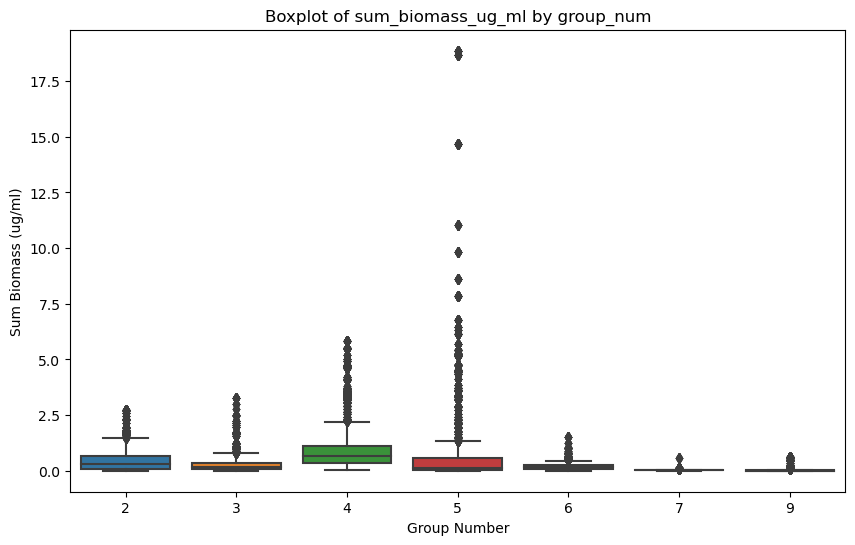

In [17]:
boxplot(merged_df)

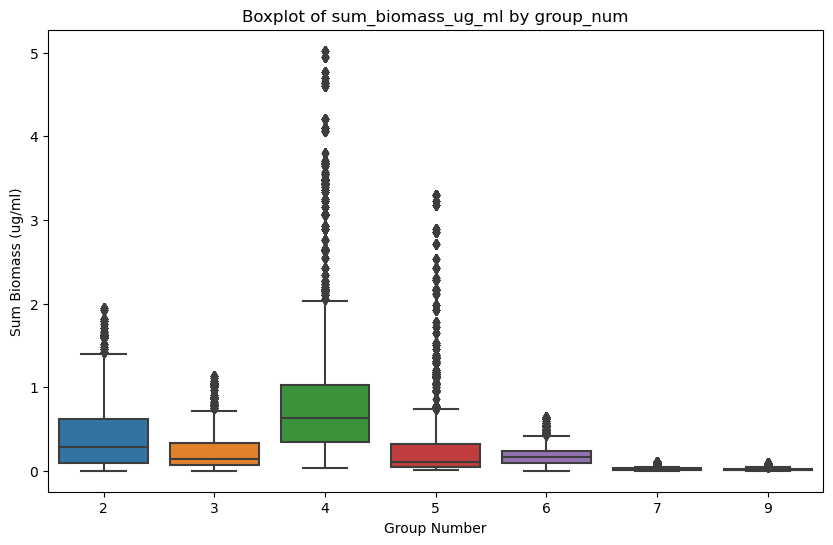

In [18]:
filtered_df = remove_outliers_IQR(merged_df, q1=0.1, q3=0.85)
merged_df = filtered_df
boxplot(filtered_df)

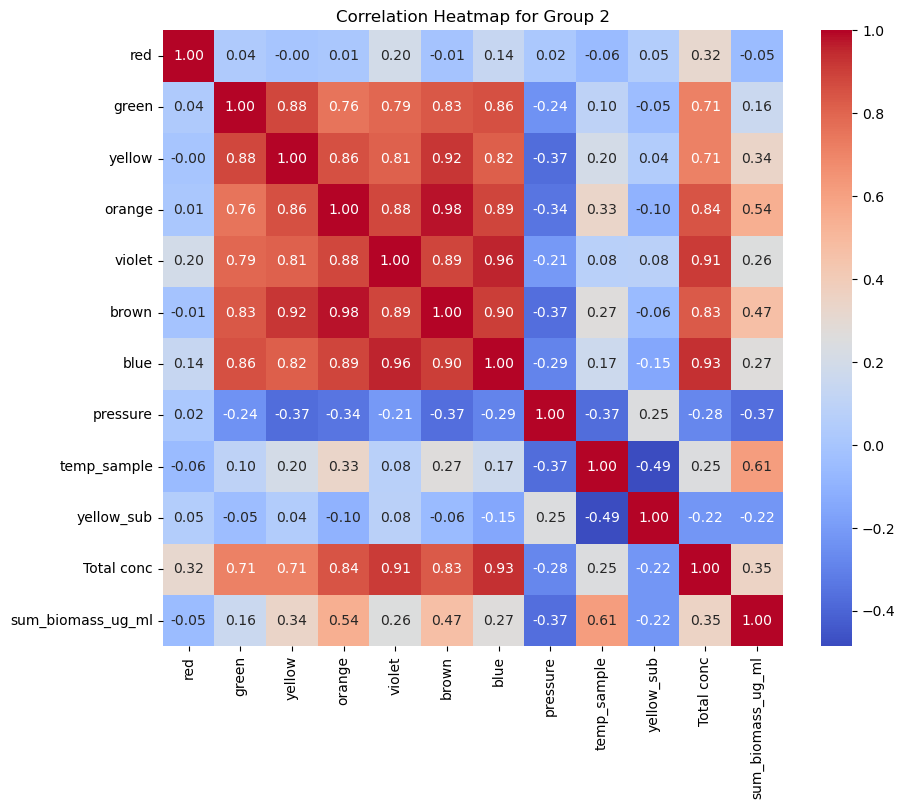

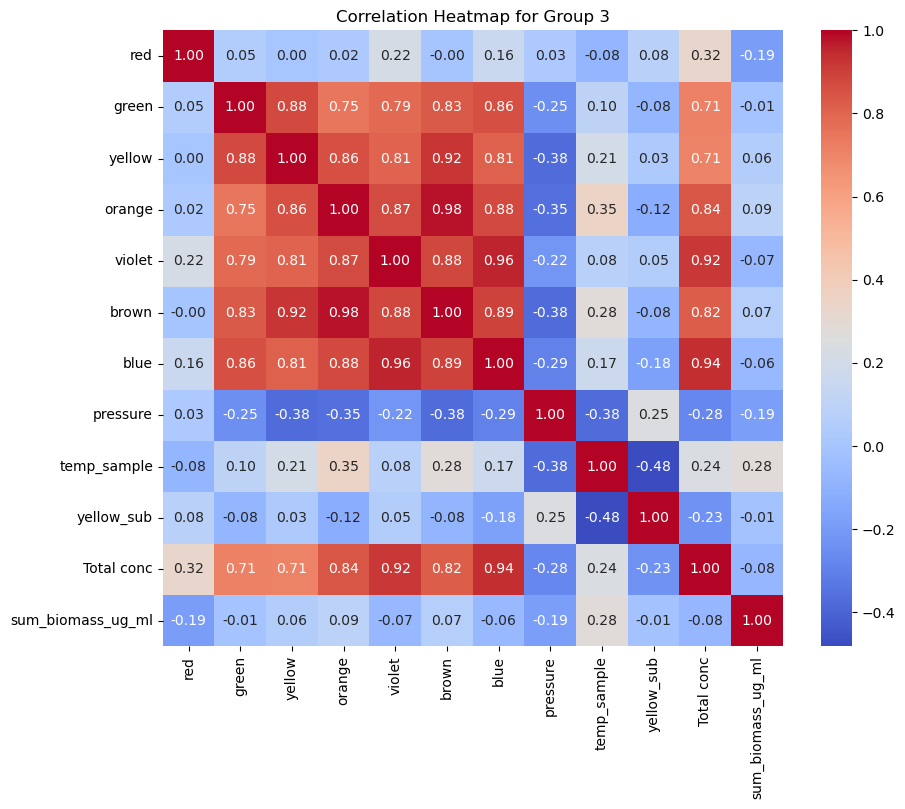

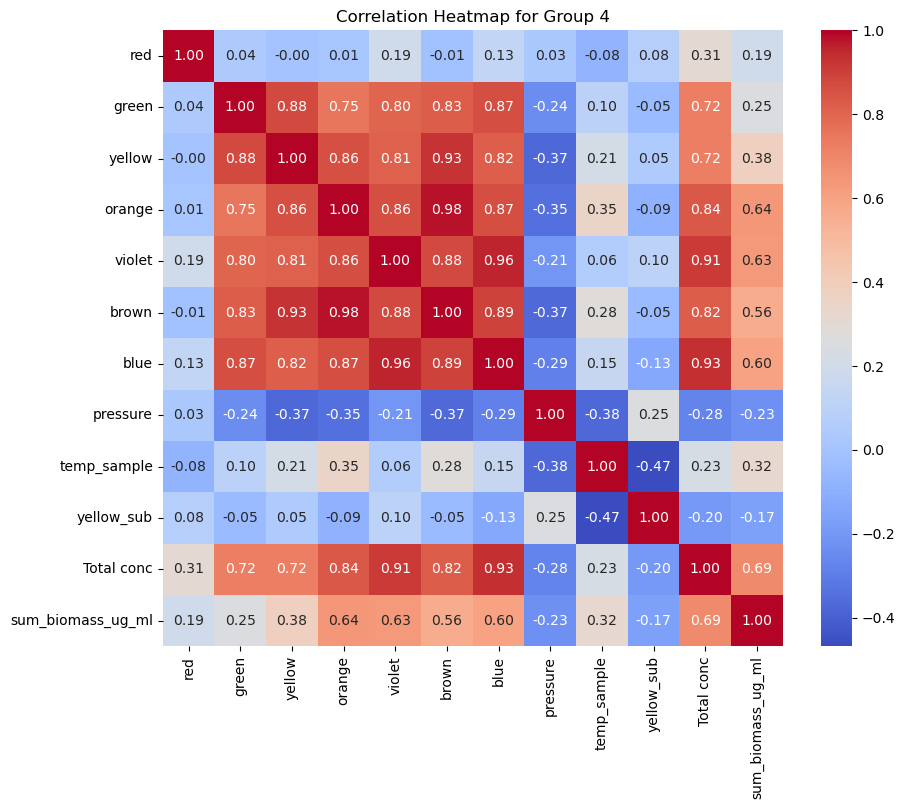

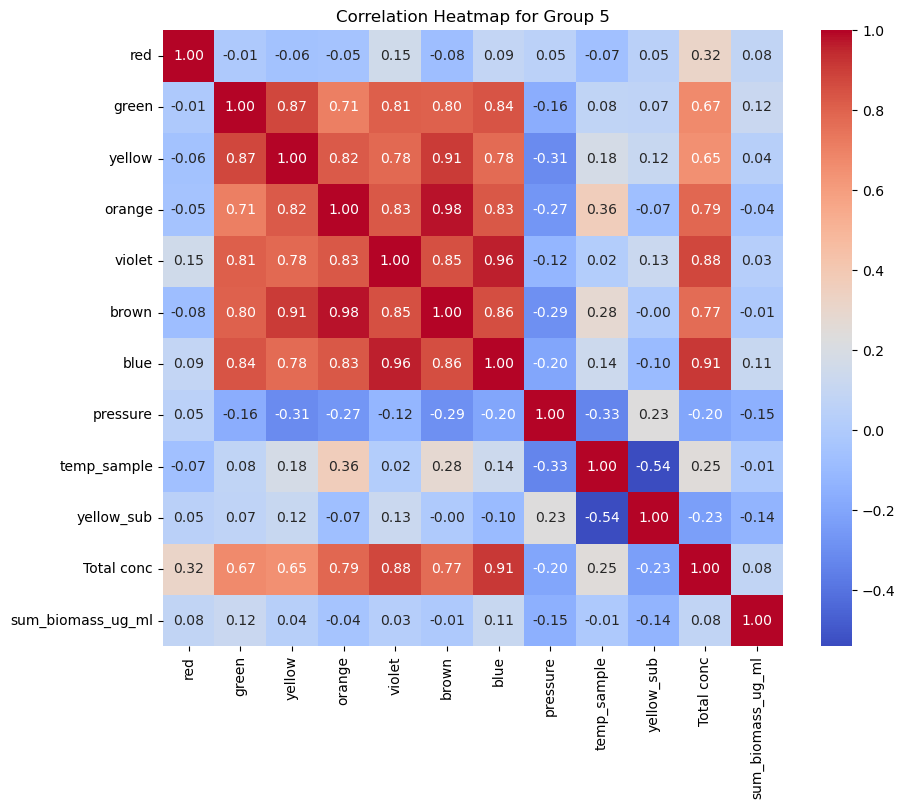

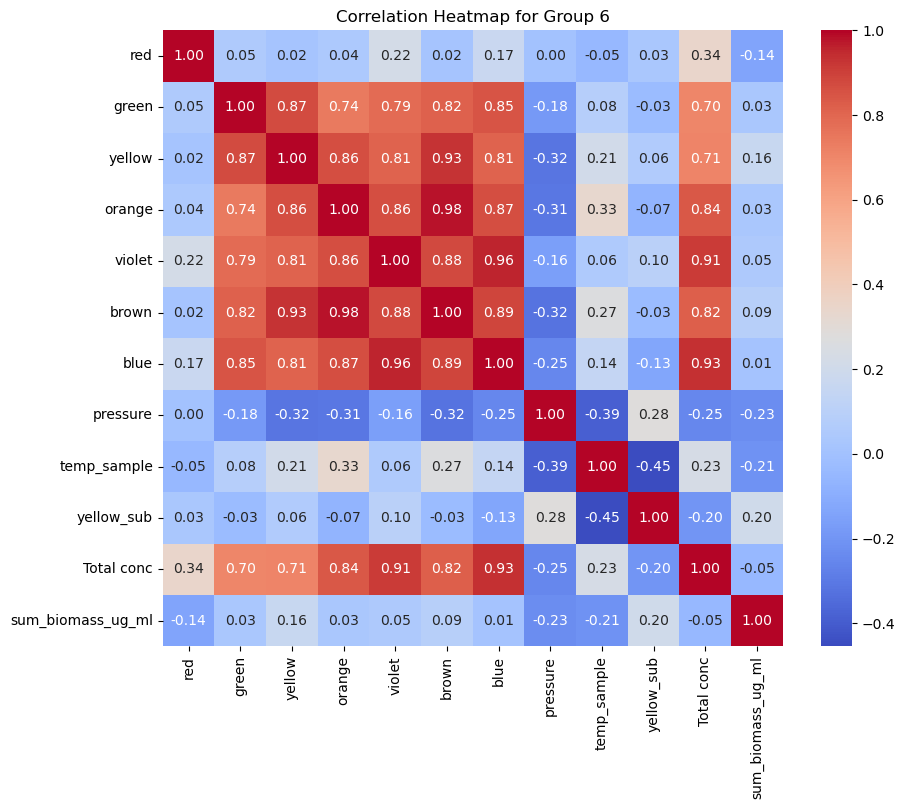

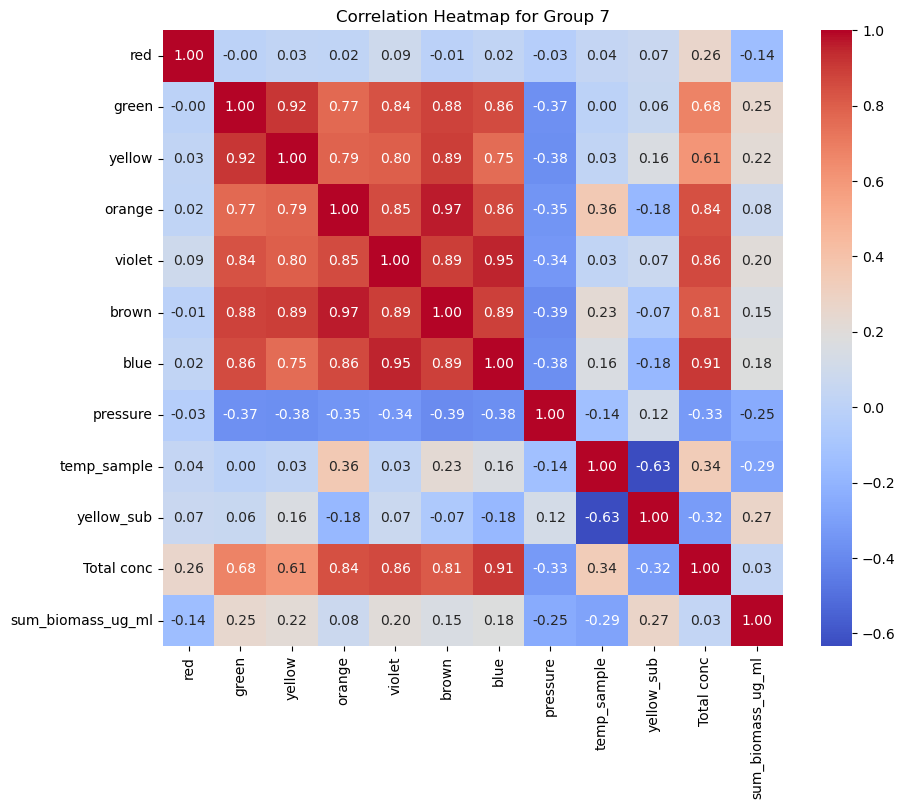

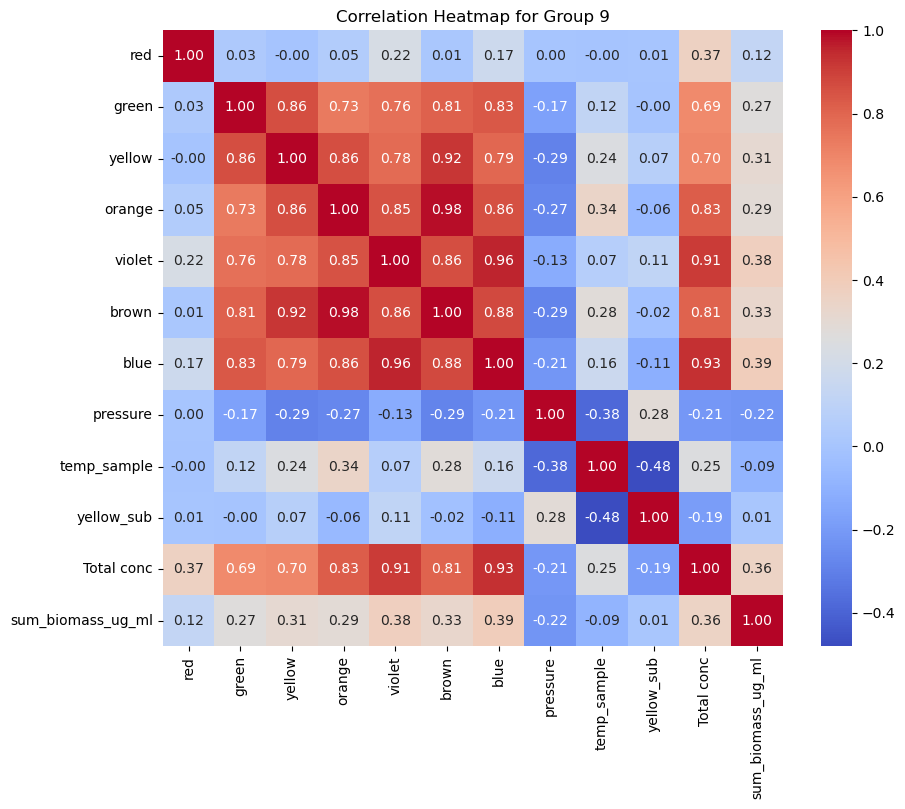

In [22]:
correlation_per_group(merged_df)

In [23]:
# keep_cols = ['red', 'green', 'orange', 'pressure', 'temp_sensor', 'Total conc', 'sum_biomass_ug_ml', 'group_num']

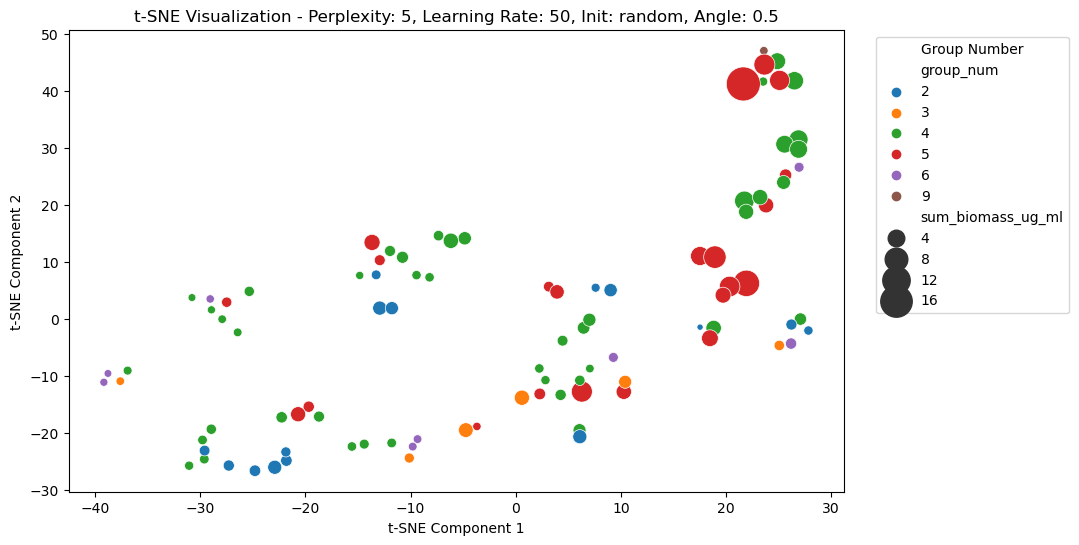

In [24]:
plot_tsne(orig_merged_df)

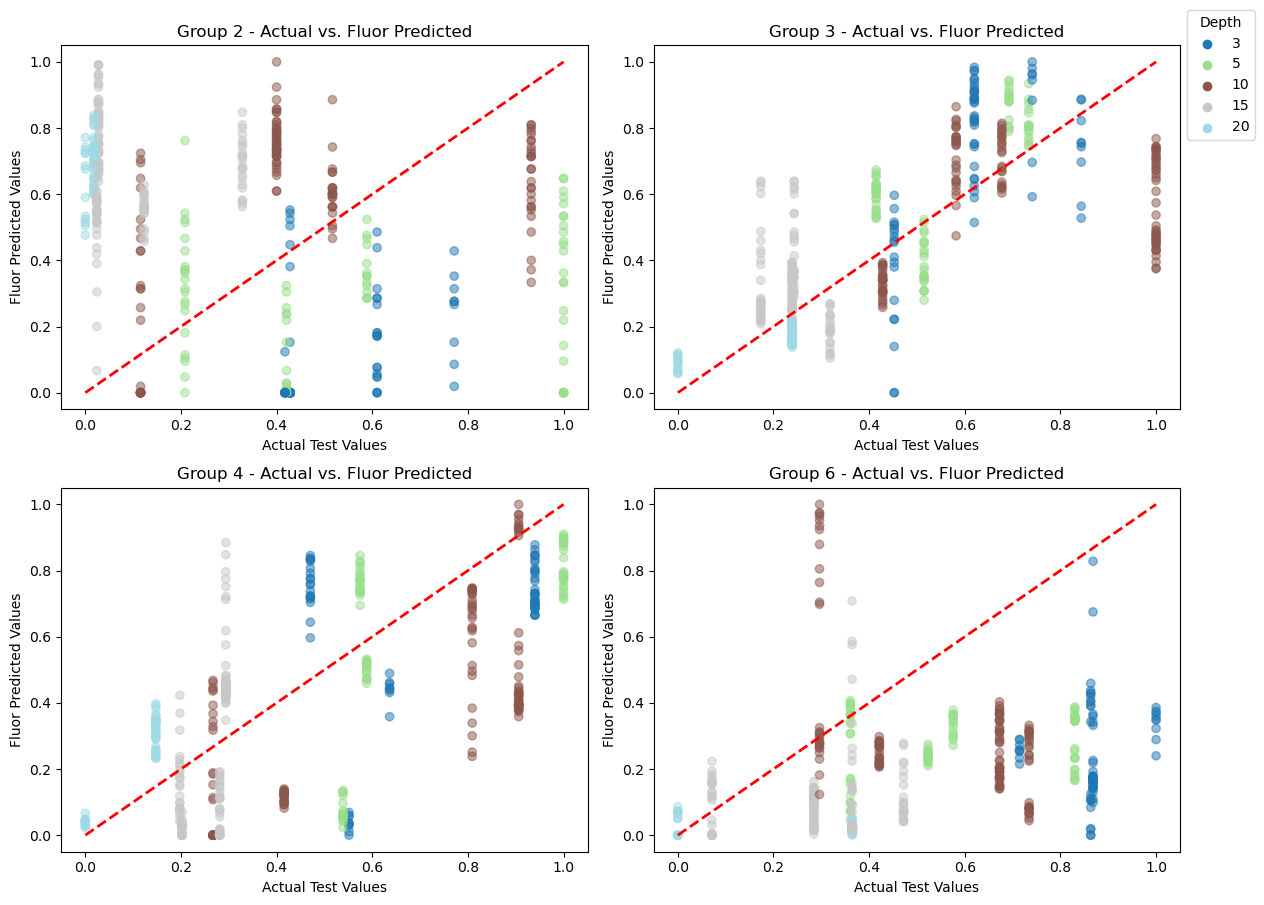

In [25]:
plot_fluorprobe_prediction(fluor_test_df, fluor_groups_map)

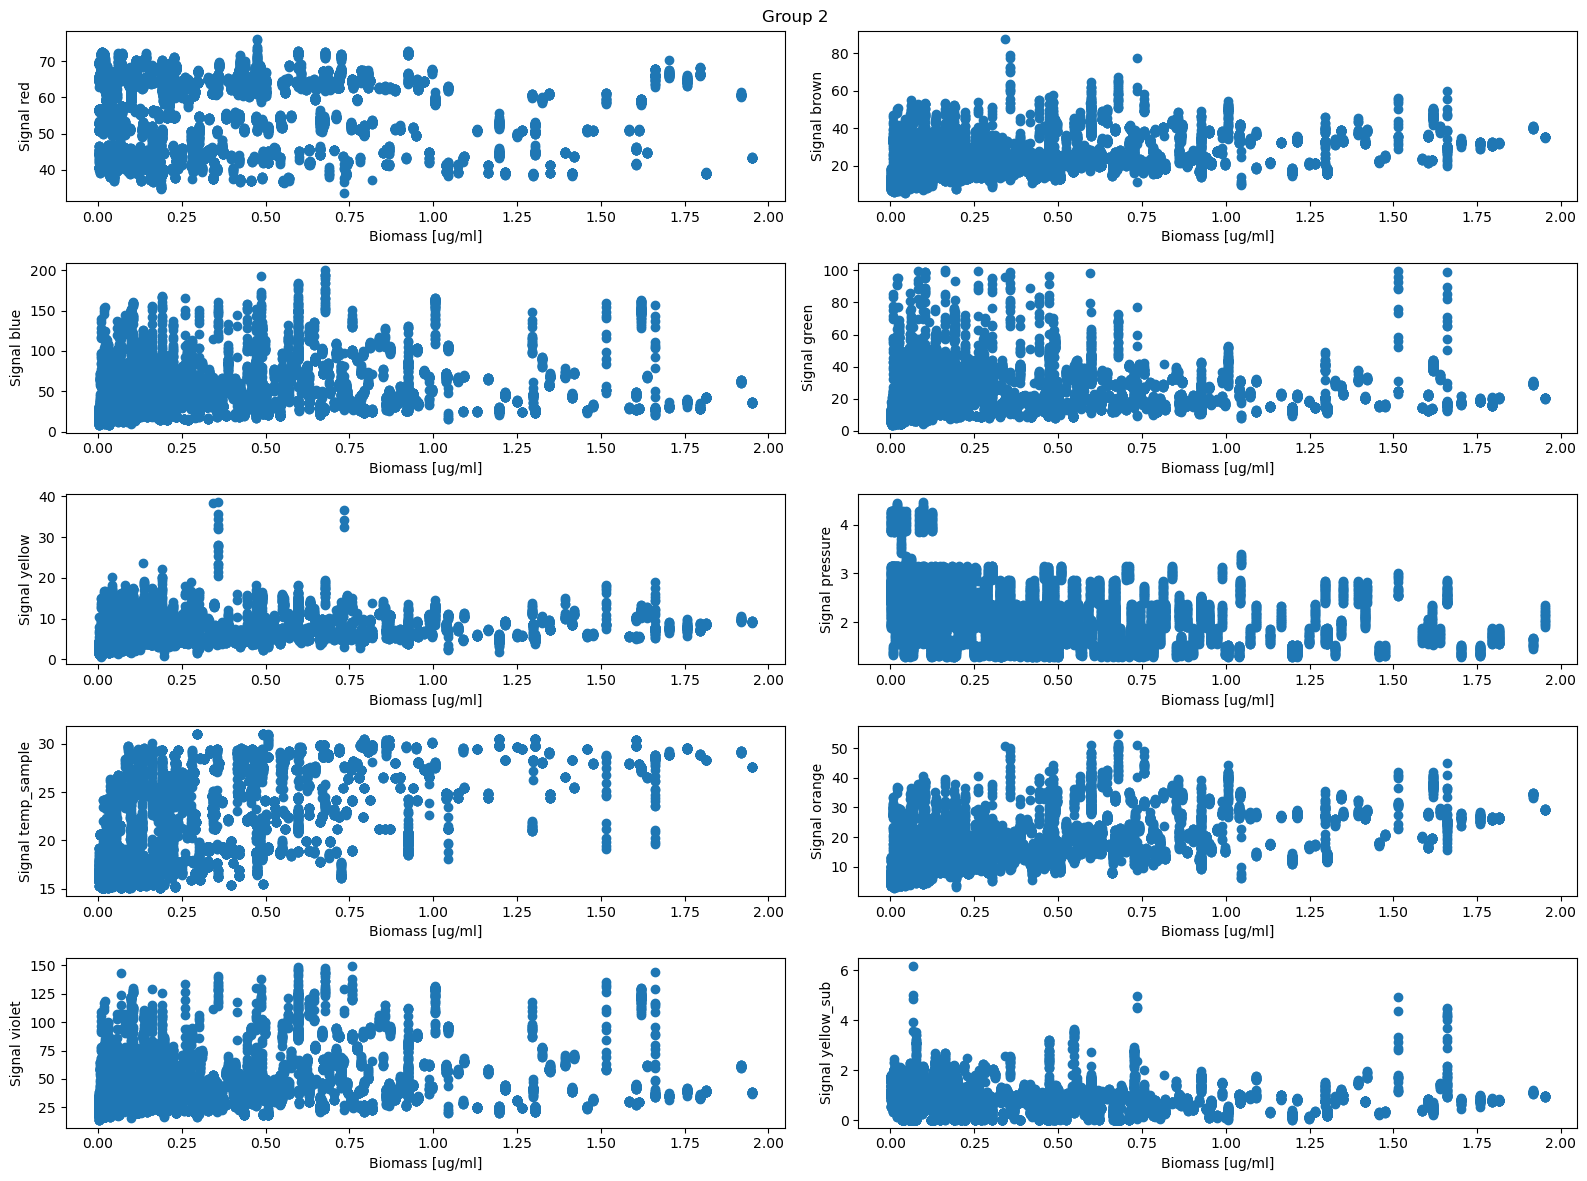

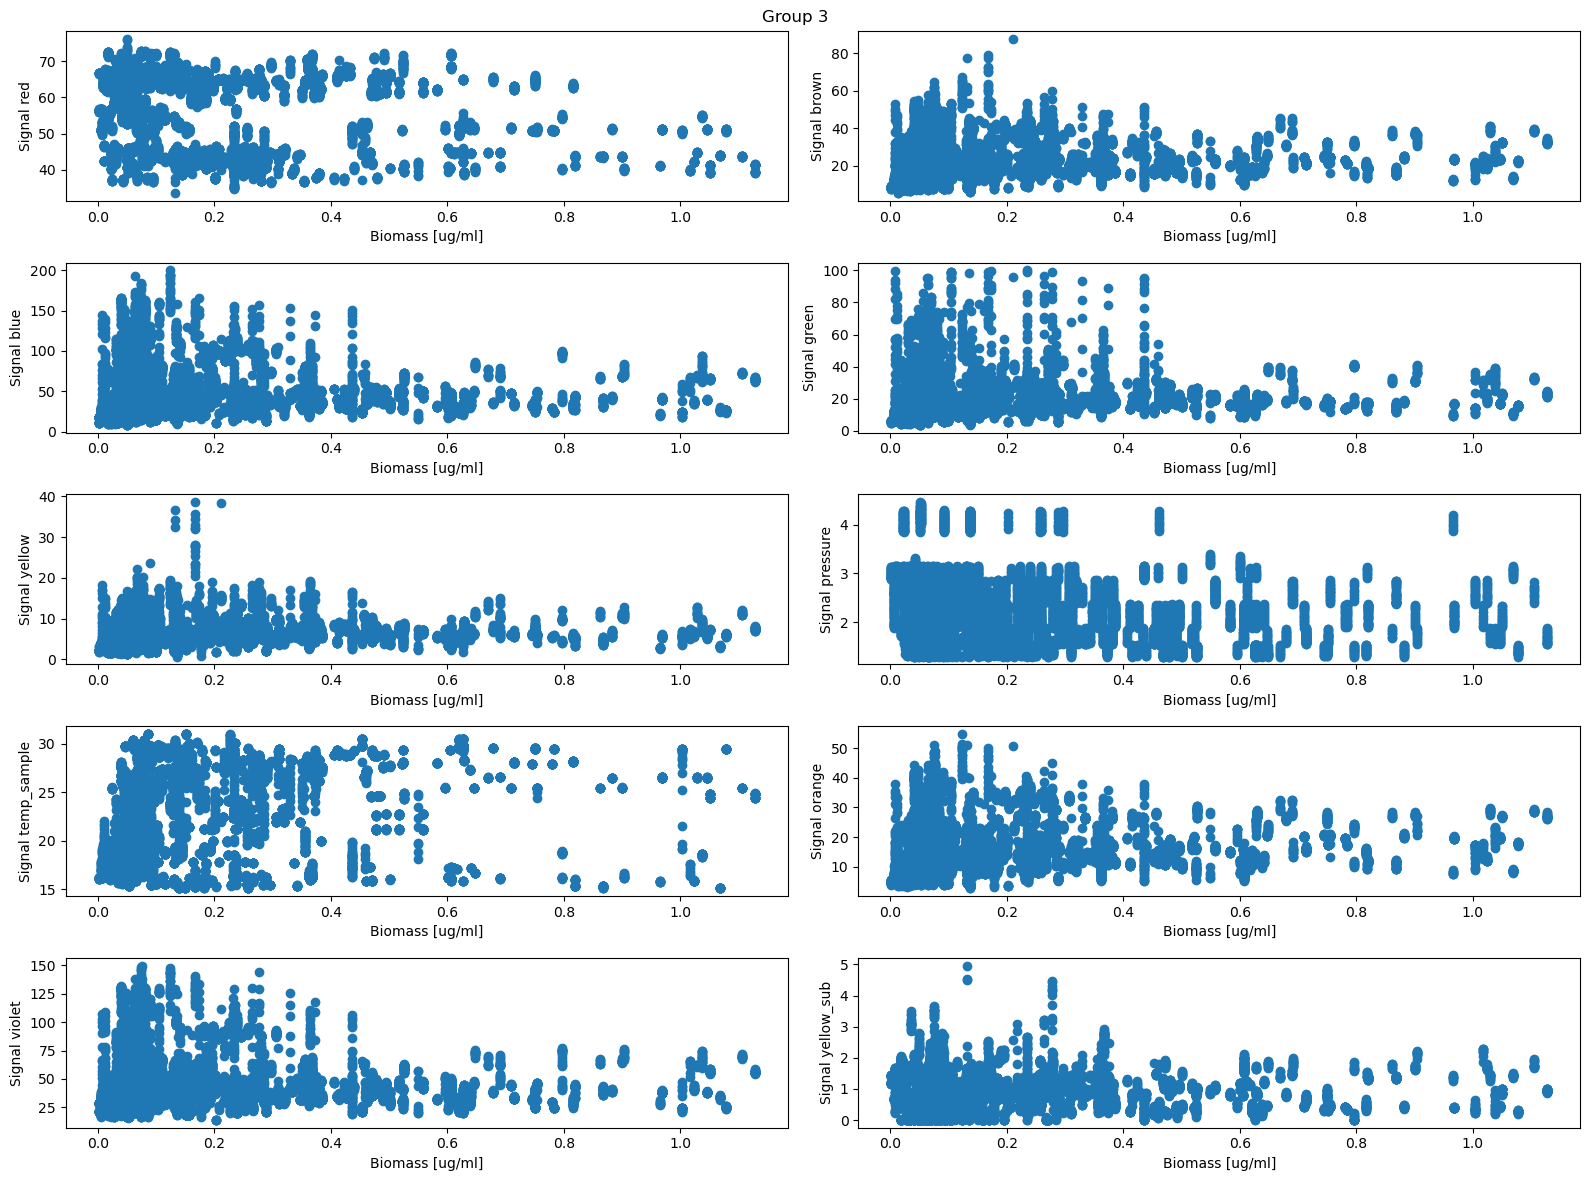

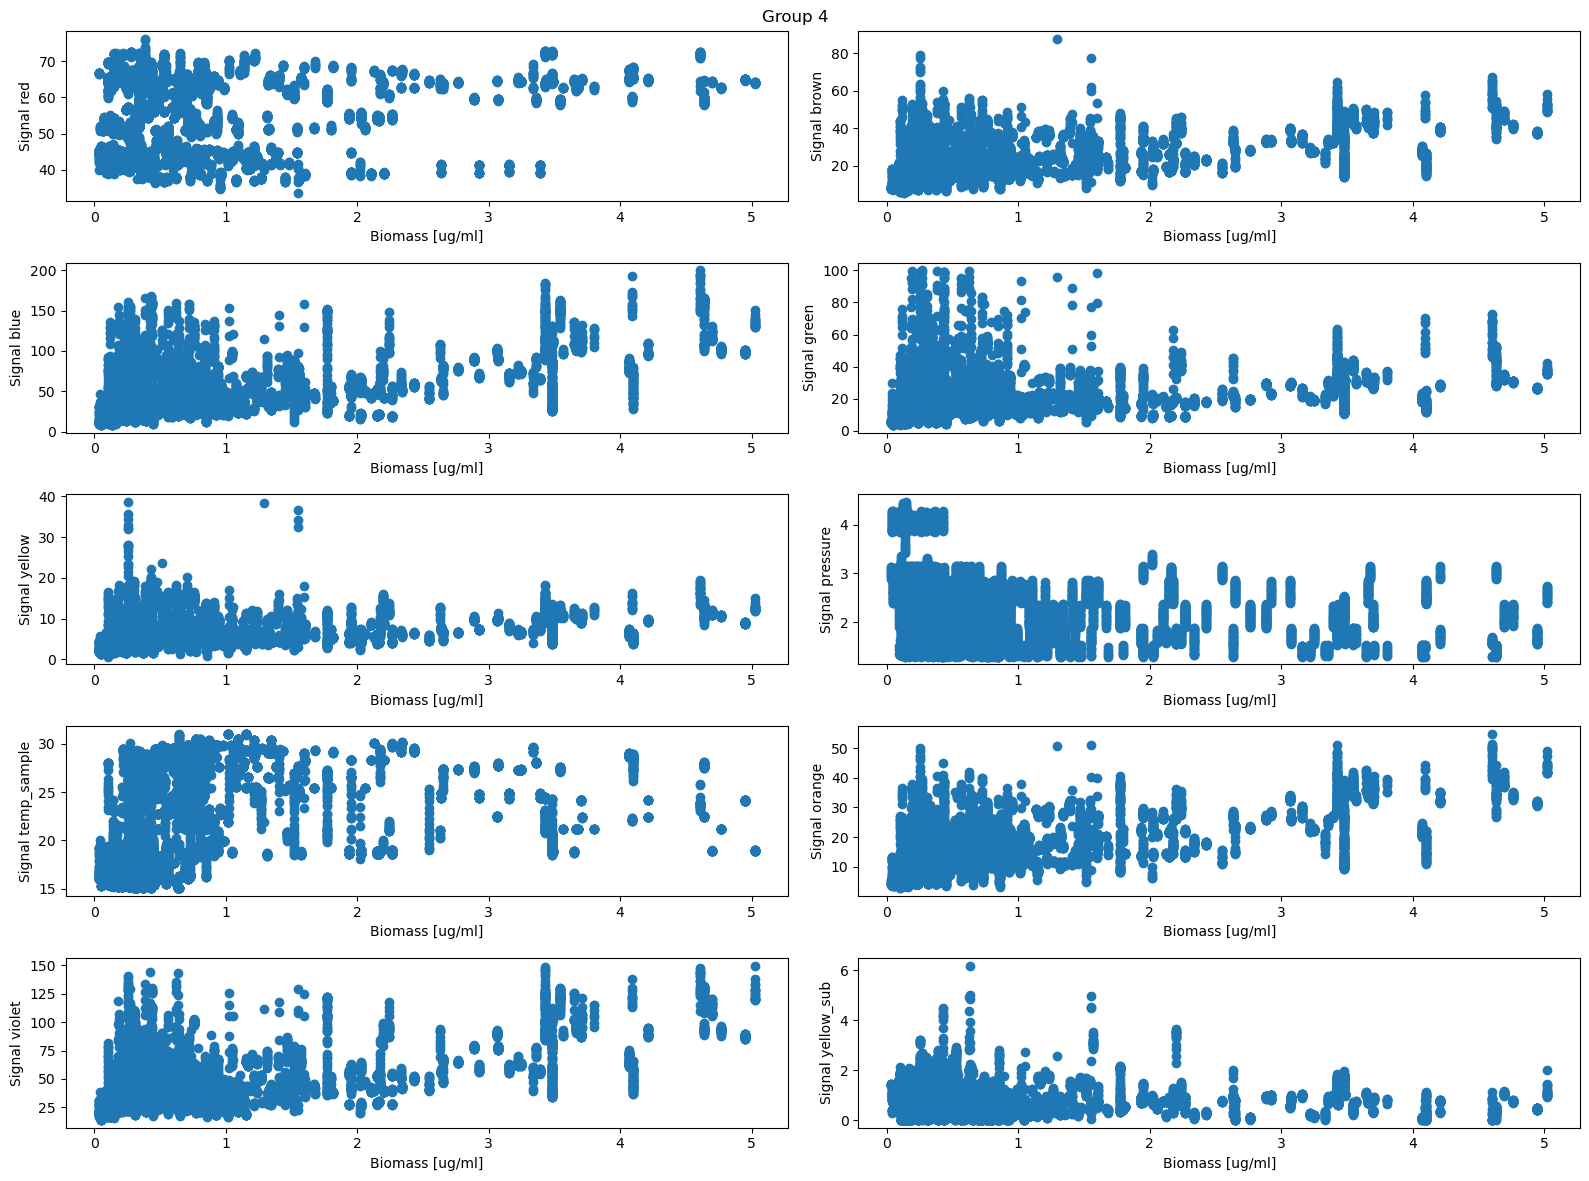

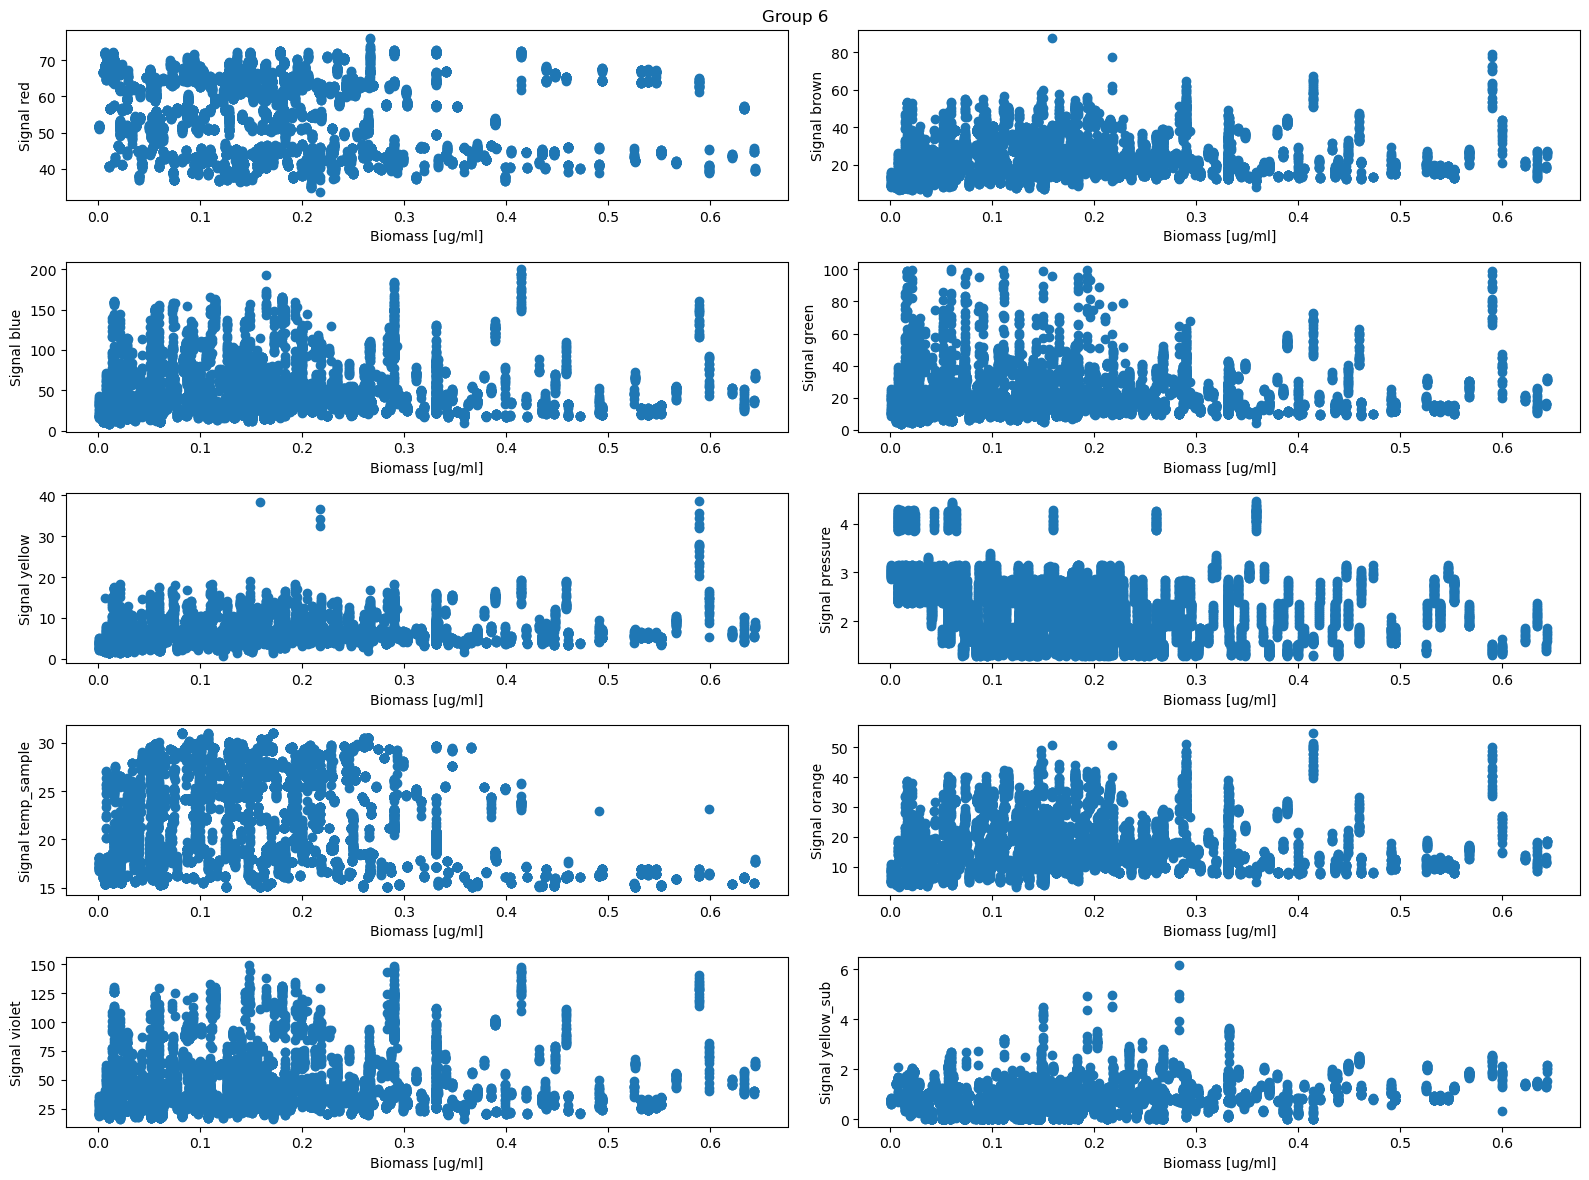

In [31]:
plot_corr_per_feature_per_group(merged_df, fluor_groups_map)

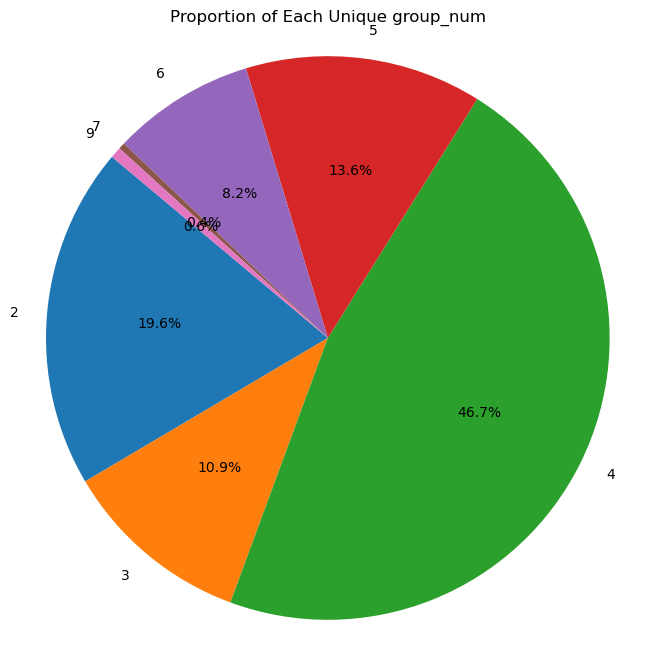

In [32]:
groups_pie_chart(merged_df, by_biomass=True)

In [33]:
merged_df = merged_df.drop(['year', 'Depth'], axis=1)
merged_df_test = merged_df_test.drop(['year', 'Depth'], axis=1)
fluor_test_df = fluor_test_df.drop('Depth', axis=1)

# Training models and evaluating

## Grid Search per model

In [36]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

In [37]:
if do_search:
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 800], # Number of boosting rounds
        "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
        "model__max_depth": [3, 5, 7], # Maximum depth of a tree,
        'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
        "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
        "model__colsample_bytree": [0.8, 1.0] # Fraction of features used for fitting trees
    },
    'svr':  {
        "model__C": [1, 10, 100], # Regularization parameter
        "model__kernel": ["poly", "rbf"],
        "model__degree": [2, 3], # Degree of the polynomial kernel (for "poly" kernel)
        "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
        "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_df, param_grid=param_grid)
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

## Retraining After Grid Search

In [46]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train('xgb', merged_df, group_kwargs=best_group_params_fixed, test_size=0.0, biomass_factor=100)

[23:11:32] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "degree", "epsilon", "kernel", "tol" } are not used.

[23:11:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "degree", "epsilon", "kernel", "tol" } are not used.

[23:11:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "degree", "epsilon", "kernel", "tol" } are not used.

[23:11:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "degree", "epsilon", "kernel", "tol" } are not used.

[23:11:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "degree", "epsilon", "kernel", "tol" } are not used.

[23:11:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "C", "degree", "epsilon", "kernel", "tol" } are not used.

[23:11:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:7

## Linear Regression

In [47]:
regression_models['lr'], _ = train('lr', merged_df, test_size=0.0, biomass_factor=100)

## Comparing All Models

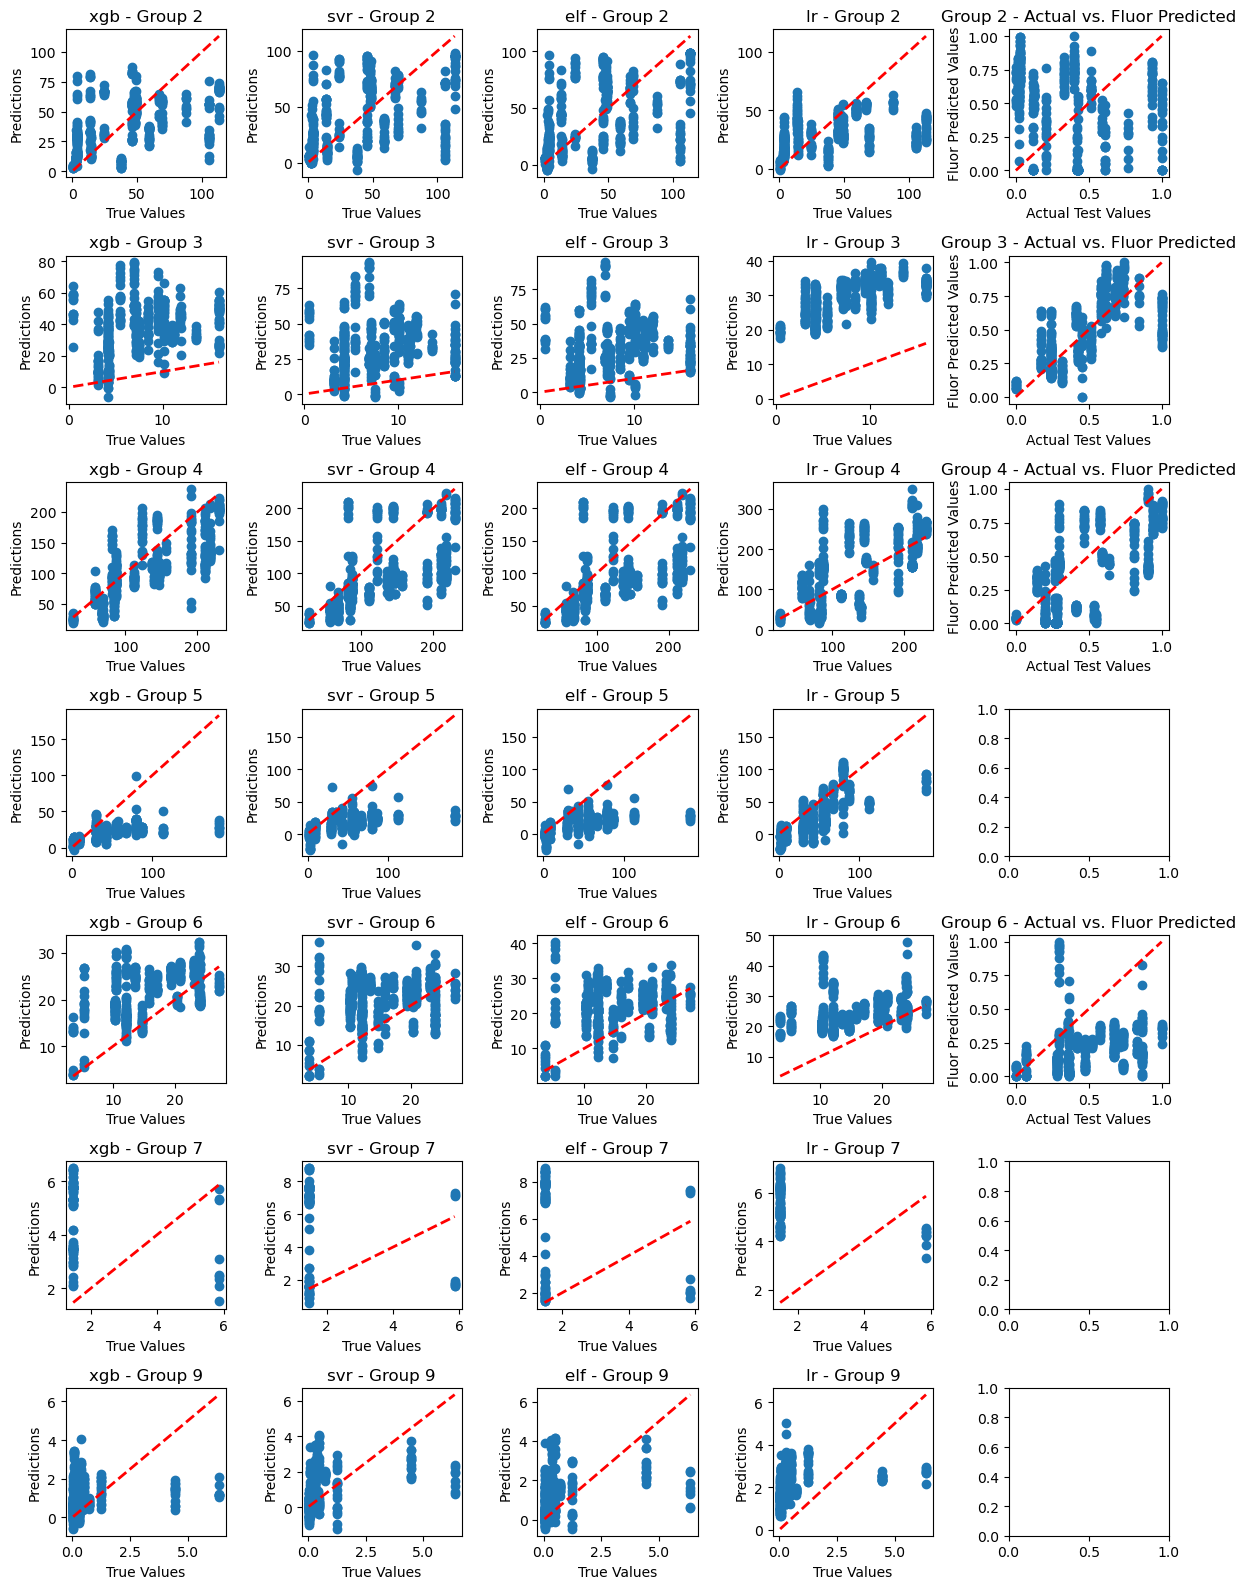

In [48]:
comparing_df = compare_all_models(regression_models, merged_df_test, fluor_test_df, fluor_groups_map, biomass_factor=100)

In [49]:
comparing_df.groupby('Model')[['RMSE', 'R-squared']].mean()

RMSE  R-squared
Model                     
FP     0.341050  -0.631330
elf    0.351552  -1.109434
lr     0.335049  -0.961008
svr    0.352596  -1.136755
xgb    0.322183  -0.883633

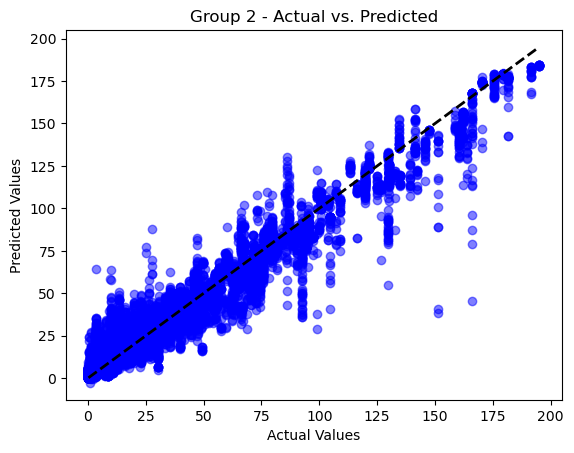

Results for group_num 2:
MSE: 100.13407491945146
R-squared: 0.9401970966612835



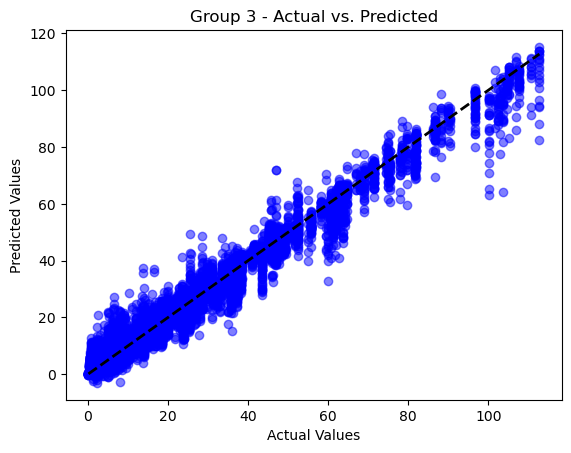

Results for group_num 3:
MSE: 14.528877201044107
R-squared: 0.9715714319721203



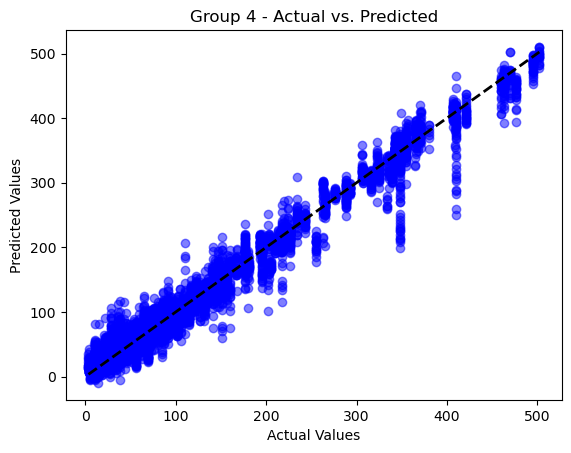

Results for group_num 4:
MSE: 220.00639412941896
R-squared: 0.9802829197471281



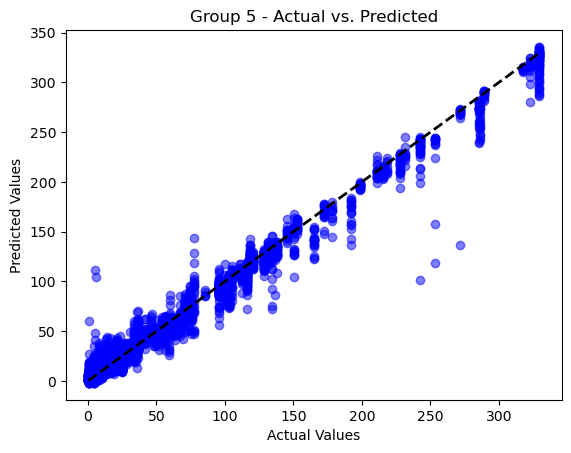

Results for group_num 5:
MSE: 50.295274865179074
R-squared: 0.9847335168338425



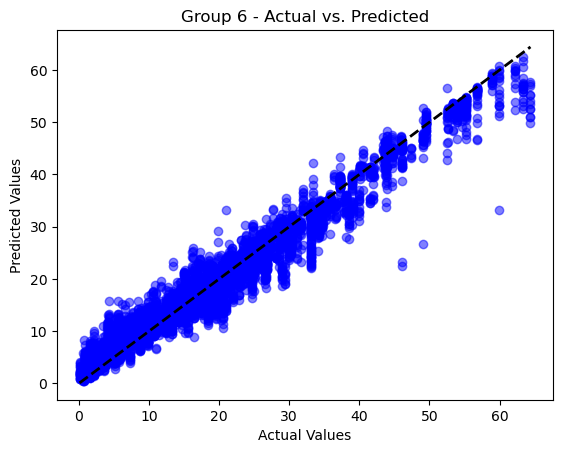

Results for group_num 6:
MSE: 5.23555752388802
R-squared: 0.9603869211289318



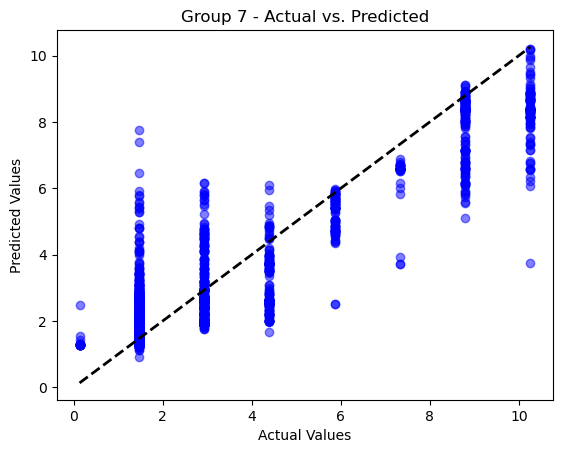

Results for group_num 7:
MSE: 0.9452919902887641
R-squared: 0.8575215477146789



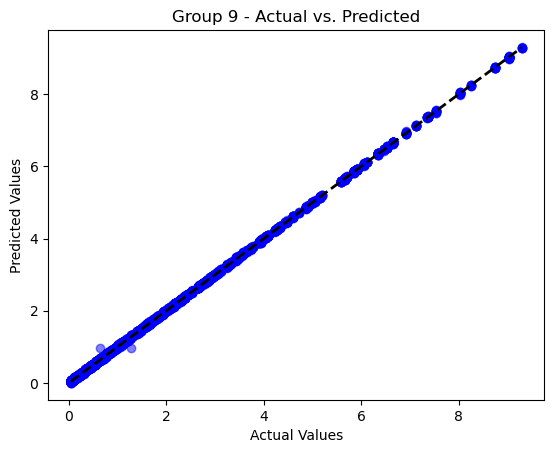

Results for group_num 9:
MSE: 0.00021285734404747928
R-squared: 0.9999273929121494

Total MSE: 55.87795478380206, Total R-squared: 0.9563744038528764


In [50]:
eval_test(regression_models['xgb'], merged_df, biomass_factor=100)

## Linear Regression

In [43]:
regression_models['lr'], _ = train('lr', merged_df, test_size=0.0, biomass_factor=100)

In [37]:
# eval_test(regression_models_lr, merged_df_test, biomass_factor=100)

In [38]:
# residual_analysis(merged_df_test, regression_models_lr, biomass_factor=100)

## XGBoost

In [54]:
# keep_cols = merged_df.columns

In [55]:
# from sklearn.feature_selection import SelectKBest, f_regression
# selkbest= SelectKBest(f_regression, k=5)
# X_new = selkbest.fit_transform(merged_df.drop('sum_biomass_ug_ml', axis=1), merged_df['sum_biomass_ug_ml'])

In [56]:
# selkbest.get_feature_names_out()

In [57]:
# keep_cols = ['orange', 'brown', 'blue', 'Total conc', 'group_num', 'sum_biomass_ug_ml']

In [60]:
# regression_models_xgboost, preds_real_y_xgboost = train('xgb', merged_df, test_size=0.0, biomass_factor=100)

In [ ]:
# eval_test(regression_models_xgboost, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_xgboost, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)

In [ ]:
# residual_analysis(merged_df_test, regression_models_xgboost, biomass_factor=100)

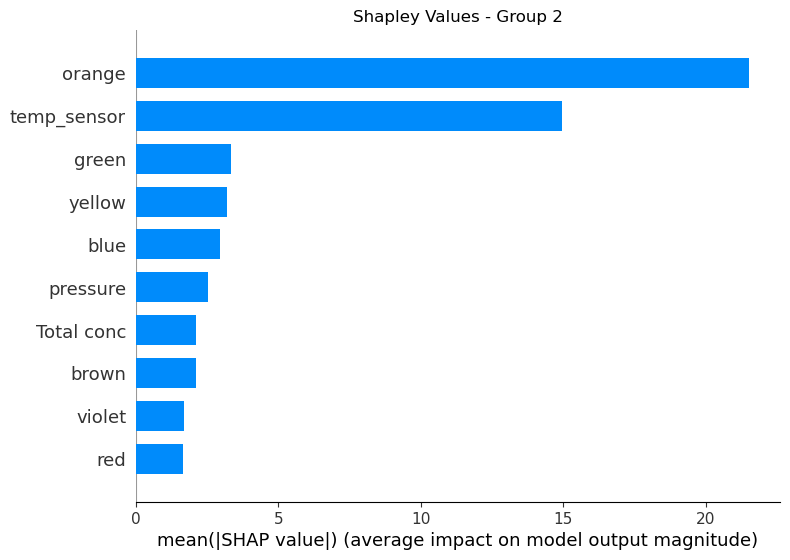

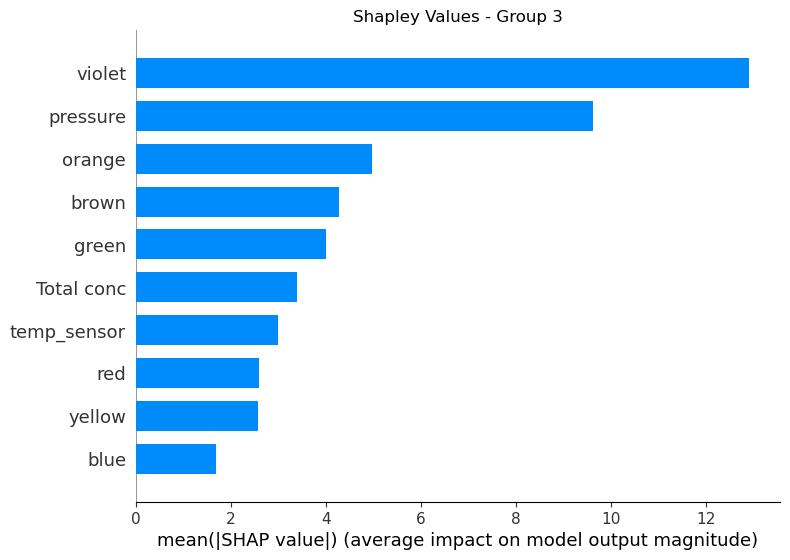

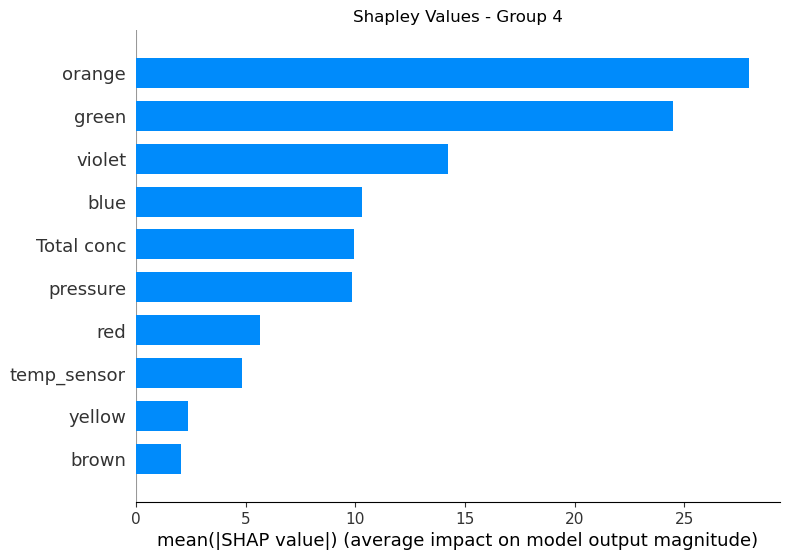

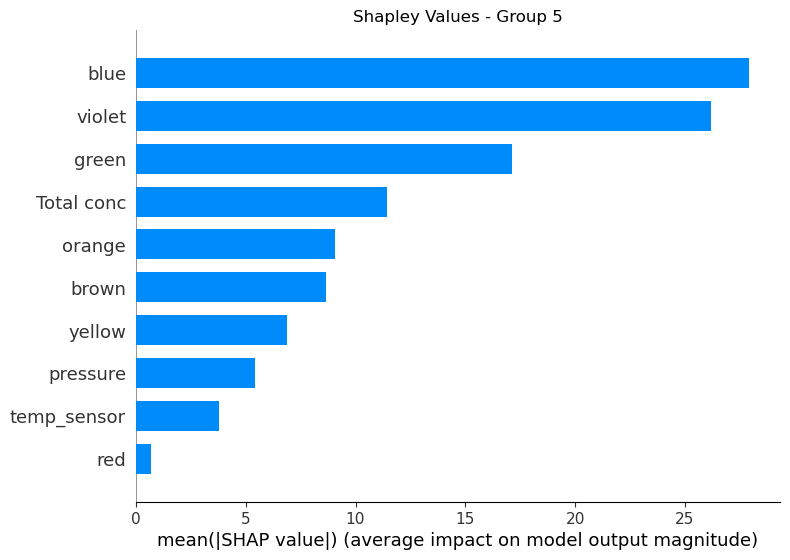

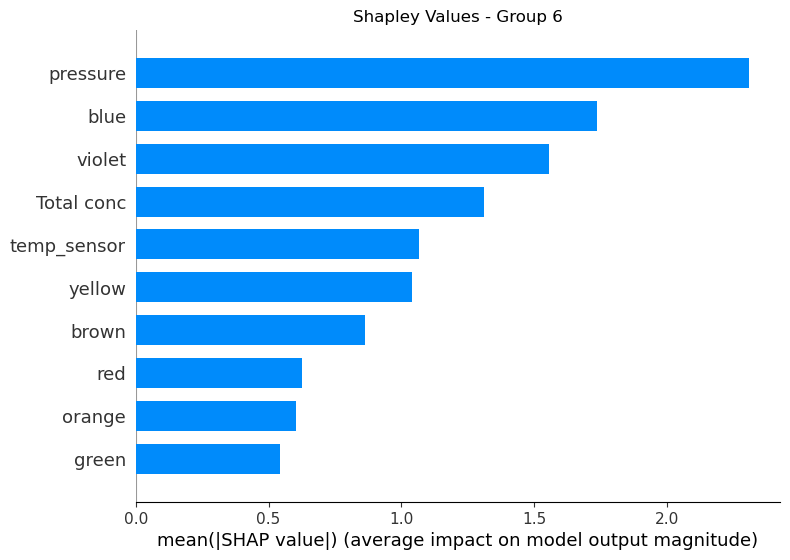

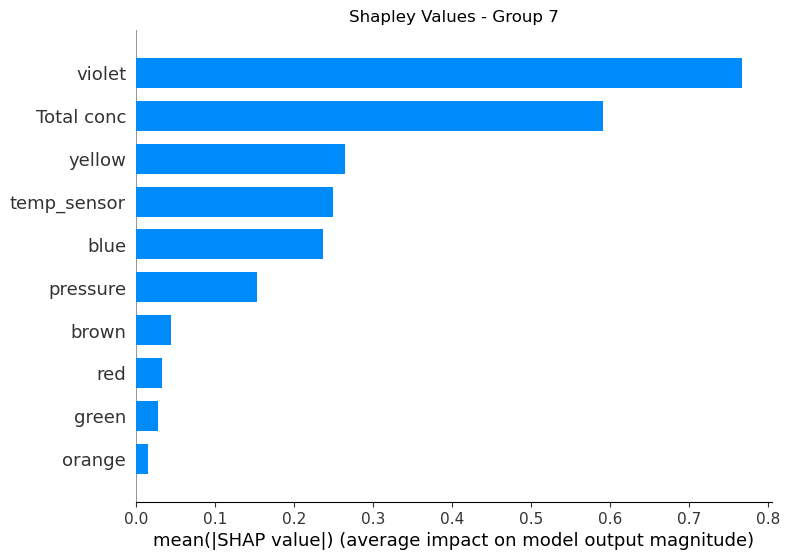

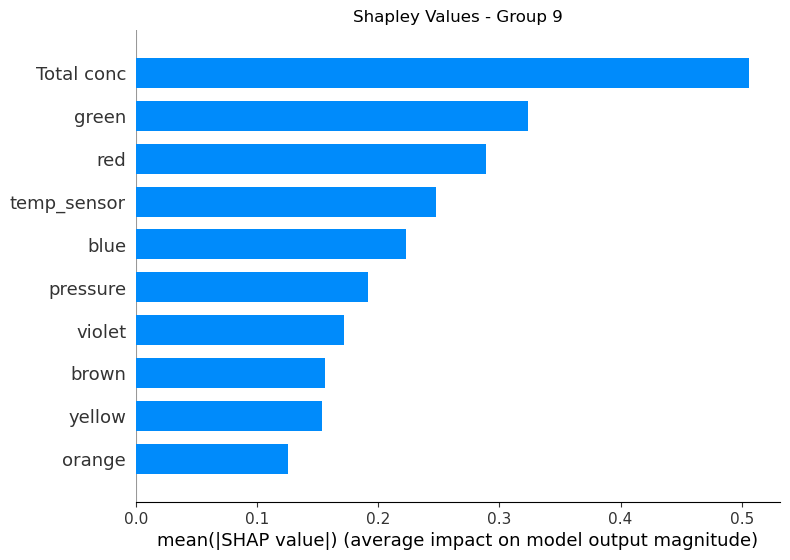

In [74]:
shap_values_list = plot_shap_values(merged_df_test, regression_models_xgboost, merged_df_test)

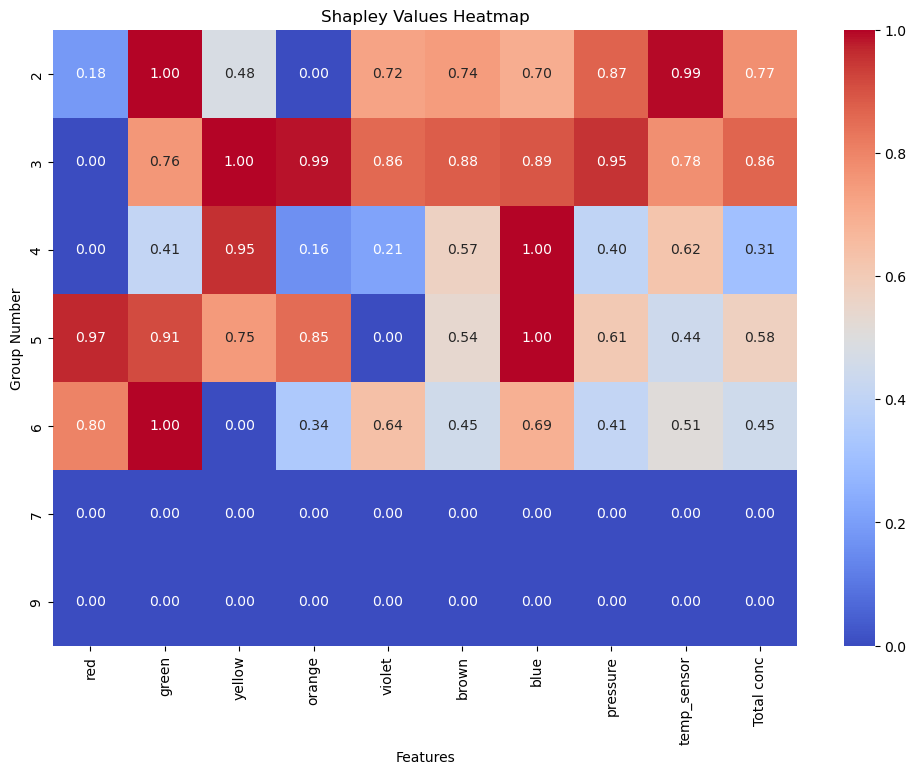

In [83]:
features_list = merged_df_test.drop(['group_num', 'sum_biomass_ug_ml'], axis=1).columns.tolist()

# Create a DataFrame from the Shapley values
shap_df = pd.DataFrame({k: np.average(v.values, axis=0) for k, v in shap_values_list.items()}, index=features_list)

scaler = MinMaxScaler()
scaled_shap_df = pd.DataFrame(scaler.fit_transform(shap_df), columns=shap_df.columns, index=shap_df.index)
    
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scaled_shap_df.transpose(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Shapley Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Group Number")
plt.show()


## SVR

In [101]:
# regression_models_svr, preds_real_y_xgboost = train('svr', merged_df, test_size=0.0, biomass_factor=100, group_kwargs=group_kwargs)

In [ ]:
# eval_test(regression_models_svr, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_svr, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)

## ElasticNet Regression

In [ ]:
# regression_models_elf, preds_real_y_xgboost = train('elf', merged_df, test_size=0.0, biomass_factor=100)

In [ ]:
# eval_test(regression_models_elf, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_elf, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)